In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as transforms
from torchvision import datasets
from PIL import ImageFile
import torchvision
from skimage.util import montage
import os
import cv2 
import random
import matplotlib.pyplot as plt 
import torch.optim as optim
from PIL import Image
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from torch.utils.tensorboard import SummaryWriter
import glob
import shutil
import numpy as np
from torchvision.models import vgg19_bn
import numpy as np
import seaborn as sns
import torchvision.models as models

<ipython-input-2-4ea89b20fa06>:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(len(covid_images) / columns + 1, columns, i + 1)


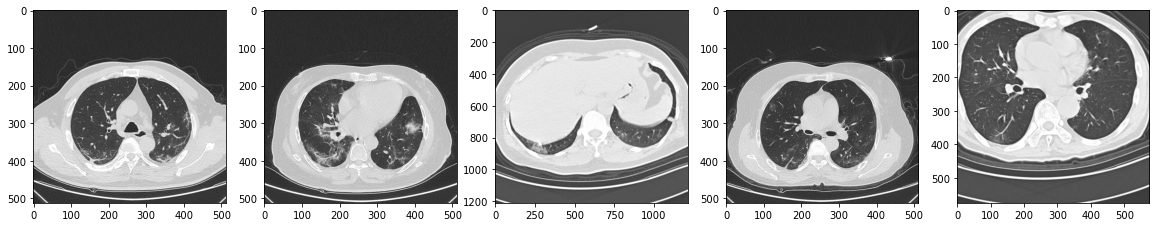

In [2]:
covid_files_path = 'D:/Datasets/COVID-CT/train/pCT'
covid_files = [os.path.join(covid_files_path, x) for x in os.listdir(covid_files_path)]
covid_images = [cv2.imread(x) for x in random.sample(covid_files, 5)]

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(covid_images):
    plt.subplot(len(covid_images) / columns + 1, columns, i + 1)
    plt.imshow(image)

In [ ]:
train_test_eval_dirs = ['train/pCT', 'train/nCT', 'test/pCT',
                   'test/nCT', 'validation/pCT', 'validation/nCT']

In [ ]:
main_path = 'D:/Datasets/COVID-CT/'
for dirc in train_test_eval_dirs:
    if not os.path.exists(os.path.join(main_path, dirc)):
        os.makedirs(os.path.join(main_path, dirc))

In [ ]:
def move_to_destination(origin, destination, percentage_split):
    num_images = int(len(os.listdir(origin))*percentage_split)
    for img_name, img_number in zip(sorted(os.listdir(origin)), range(num_images)):
        shutil.move(os.path.join(origin, img_name), destination)

In [ ]:
move_to_destination('D:/Datasets/COVID-CT/pCT', os.path.join(main_path, r'train/pCT'), 0.7)
move_to_destination('D:/Datasets/COVID-CT/nCT', os.path.join(main_path, 'train/nCT'), 0.7)


move_to_destination('D:/Datasets/COVID-CT/pCT', os.path.join(main_path, r'test/pCT'), 0.2)
move_to_destination('D:/Datasets/COVID-CT/nCT', os.path.join(main_path, 'test/nCT'), 0.2)

move_to_destination('D:/Datasets/COVID-CT/pCT', os.path.join(main_path, r'validation/pCT'), 1)
move_to_destination('D:/Datasets/COVID-CT/nCT', os.path.join(main_path, r'validation/nCT'), 1)

In [3]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
#define transforms
train_transforms = transforms.transforms.Compose([transforms.Resize(256), 
                                transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomRotation(15),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])])

test_transforms = transforms.transforms.Compose([transforms.Resize(256), 
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])])


validation_transforms = transforms.transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])])

In [5]:
train_data = datasets.ImageFolder('D:/Datasets/COVID-CT/train', transform=train_transforms)
validation_data = torchvision.datasets.ImageFolder('D:/Datasets/COVID-CT/validation', transform=validation_transforms)
test_data = torchvision.datasets.ImageFolder('D:/Datasets/COVID-CT/test', transform=test_transforms)

train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=32, num_workers=0)
valid_loader = torch.utils.data.DataLoader(validation_data, shuffle=False, batch_size=16, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=False, batch_size=16, num_workers=0)


loaders = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

In [13]:
use_cuda = torch.cuda.is_available()

model_transfer = models.vgg19_bn(pretrained=True)

for param in model_transfer.parameters():
    param.requires_grad = False

model_transfer.classifier[6] = nn.Linear(4096, 2)

if use_cuda:
    model_transfer = model_transfer.cuda()

In [14]:
import torch.optim as optim
#loss function
criterion_transfer = nn.CrossEntropyLoss()

#optimizer
optimizer_transfer = optimizer = optim.SGD(model_transfer.parameters(), lr=0.01, momentum=0.9)

In [15]:
import numpy as np
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):

    valid_loss_min = np.Inf
    
    print(f"Batch Size: {loaders['train'].batch_size}\n")
    
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
         
        # train the model
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            if (batch_idx + 1) % 5 == 0:
                print(f'Epoch:{epoch}/{n_epochs} \tBatch:{batch_idx + 1}')
                print(f'Train Loss: {train_loss}\n')

        # validate the model
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            with torch.no_grad():
                output = model(data)
            loss = criterion(output, target)
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
           
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        # save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model...'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [16]:
model_transfer = train(20, loaders, model_transfer, optimizer_transfer,  criterion_transfer, use_cuda, 'model_transfer.pt')

Batch Size: 32

Epoch:1/20 	Batch:5
Train Loss: 0.6743338704109192

Epoch:1/20 	Batch:10
Train Loss: 0.5120294690132141

Epoch:1/20 	Batch:15
Train Loss: 0.4609534740447998

Epoch:1/20 	Batch:20
Train Loss: 0.42048579454421997

Epoch:1/20 	Batch:25
Train Loss: 0.43090832233428955

Epoch:1/20 	Batch:30
Train Loss: 0.4416847825050354

Epoch:1/20 	Batch:35
Train Loss: 0.44639065861701965

Epoch:1/20 	Batch:40
Train Loss: 0.4253852367401123

Epoch:1/20 	Batch:45
Train Loss: 0.42204806208610535

Epoch:1/20 	Batch:50
Train Loss: 0.4158397316932678

Epoch:1/20 	Batch:55
Train Loss: 0.4113413691520691

Epoch:1/20 	Batch:60
Train Loss: 0.41827765107154846

Epoch:1/20 	Batch:65
Train Loss: 0.4204152822494507

Epoch:1/20 	Batch:70
Train Loss: 0.42960575222969055

Epoch:1/20 	Batch:75
Train Loss: 0.4303106963634491

Epoch:1/20 	Batch:80
Train Loss: 0.4402309060096741

Epoch:1/20 	Batch:85
Train Loss: 0.4446951746940613

Epoch:1/20 	Batch:90
Train Loss: 0.4412015378475189

Epoch:1/20 	Batch:95
Trai

Train Loss: 0.5464587807655334

Epoch:3/20 	Batch:135
Train Loss: 0.5484933853149414

Epoch:3/20 	Batch:140
Train Loss: 0.5509648323059082

Epoch:3/20 	Batch:145
Train Loss: 0.5519518852233887

Epoch:3/20 	Batch:150
Train Loss: 0.5629851222038269

Epoch:3/20 	Batch:155
Train Loss: 0.570662260055542

Epoch:3/20 	Batch:160
Train Loss: 0.5672053694725037

Epoch:3/20 	Batch:165
Train Loss: 0.571917712688446

Epoch:3/20 	Batch:170
Train Loss: 0.5720693469047546

Epoch:3/20 	Batch:175
Train Loss: 0.5713412761688232

Epoch:3/20 	Batch:180
Train Loss: 0.5648598074913025

Epoch:3/20 	Batch:185
Train Loss: 0.5650318264961243

Epoch:3/20 	Batch:190
Train Loss: 0.5672099590301514

Epoch:3/20 	Batch:195
Train Loss: 0.5663928985595703

Epoch:3/20 	Batch:200
Train Loss: 0.5628259181976318

Epoch:3/20 	Batch:205
Train Loss: 0.5578259825706482

Epoch:3/20 	Batch:210
Train Loss: 0.5543021559715271

Epoch:3/20 	Batch:215
Train Loss: 0.5581756830215454

Epoch:3/20 	Batch:220
Train Loss: 0.5566409230232239

Train Loss: 0.6424296498298645

Epoch:5/20 	Batch:280
Train Loss: 0.6465767621994019

Epoch:5/20 	Batch:285
Train Loss: 0.6494540572166443

Epoch:5/20 	Batch:290
Train Loss: 0.6584547758102417

Epoch:5/20 	Batch:295
Train Loss: 0.6528459787368774

Epoch:5/20 	Batch:300
Train Loss: 0.6542813181877136

Epoch:5/20 	Batch:305
Train Loss: 0.6586951613426208

Epoch: 5 	Training Loss: 0.659764 	Validation Loss: 0.762777
Epoch:6/20 	Batch:5
Train Loss: 0.38088536262512207

Epoch:6/20 	Batch:10
Train Loss: 0.6758006811141968

Epoch:6/20 	Batch:15
Train Loss: 0.6143885850906372

Epoch:6/20 	Batch:20
Train Loss: 0.7276242971420288

Epoch:6/20 	Batch:25
Train Loss: 0.7701727151870728

Epoch:6/20 	Batch:30
Train Loss: 0.7463887929916382

Epoch:6/20 	Batch:35
Train Loss: 0.730449914932251

Epoch:6/20 	Batch:40
Train Loss: 0.7063887715339661

Epoch:6/20 	Batch:45
Train Loss: 0.7114132046699524

Epoch:6/20 	Batch:50
Train Loss: 0.6815925240516663

Epoch:6/20 	Batch:55
Train Loss: 0.6759368181228638

E

Train Loss: 0.6897655725479126

Epoch:8/20 	Batch:115
Train Loss: 0.7036646008491516

Epoch:8/20 	Batch:120
Train Loss: 0.694486141204834

Epoch:8/20 	Batch:125
Train Loss: 0.6906976699829102

Epoch:8/20 	Batch:130
Train Loss: 0.701921284198761

Epoch:8/20 	Batch:135
Train Loss: 0.6918220520019531

Epoch:8/20 	Batch:140
Train Loss: 0.6935199499130249

Epoch:8/20 	Batch:145
Train Loss: 0.6903446912765503

Epoch:8/20 	Batch:150
Train Loss: 0.6845919489860535

Epoch:8/20 	Batch:155
Train Loss: 0.6858692765235901

Epoch:8/20 	Batch:160
Train Loss: 0.6782994270324707

Epoch:8/20 	Batch:165
Train Loss: 0.6809303760528564

Epoch:8/20 	Batch:170
Train Loss: 0.6795332431793213

Epoch:8/20 	Batch:175
Train Loss: 0.674289345741272

Epoch:8/20 	Batch:180
Train Loss: 0.6699285507202148

Epoch:8/20 	Batch:185
Train Loss: 0.666134238243103

Epoch:8/20 	Batch:190
Train Loss: 0.6643958687782288

Epoch:8/20 	Batch:195
Train Loss: 0.6650531888008118

Epoch:8/20 	Batch:200
Train Loss: 0.6597235798835754



Train Loss: 0.6048316359519958

Epoch:10/20 	Batch:255
Train Loss: 0.6040918827056885

Epoch:10/20 	Batch:260
Train Loss: 0.6010742783546448

Epoch:10/20 	Batch:265
Train Loss: 0.6001473069190979

Epoch:10/20 	Batch:270
Train Loss: 0.5955414175987244

Epoch:10/20 	Batch:275
Train Loss: 0.594445526599884

Epoch:10/20 	Batch:280
Train Loss: 0.5930097103118896

Epoch:10/20 	Batch:285
Train Loss: 0.5905055999755859

Epoch:10/20 	Batch:290
Train Loss: 0.5879191756248474

Epoch:10/20 	Batch:295
Train Loss: 0.588091254234314

Epoch:10/20 	Batch:300
Train Loss: 0.589762270450592

Epoch:10/20 	Batch:305
Train Loss: 0.5897356271743774

Epoch: 10 	Training Loss: 0.589018 	Validation Loss: 0.443279
Epoch:11/20 	Batch:5
Train Loss: 0.4204753041267395

Epoch:11/20 	Batch:10
Train Loss: 0.5048099160194397

Epoch:11/20 	Batch:15
Train Loss: 0.4877834916114807

Epoch:11/20 	Batch:20
Train Loss: 0.49322691559791565

Epoch:11/20 	Batch:25
Train Loss: 0.5301398634910583

Epoch:11/20 	Batch:30
Train Loss: 

Epoch:13/20 	Batch:65
Train Loss: 0.6139944791793823

Epoch:13/20 	Batch:70
Train Loss: 0.6268677711486816

Epoch:13/20 	Batch:75
Train Loss: 0.6354178190231323

Epoch:13/20 	Batch:80
Train Loss: 0.6334025263786316

Epoch:13/20 	Batch:85
Train Loss: 0.6294437050819397

Epoch:13/20 	Batch:90
Train Loss: 0.6224303245544434

Epoch:13/20 	Batch:95
Train Loss: 0.6133924126625061

Epoch:13/20 	Batch:100
Train Loss: 0.6066960096359253

Epoch:13/20 	Batch:105
Train Loss: 0.6021765470504761

Epoch:13/20 	Batch:110
Train Loss: 0.5952814817428589

Epoch:13/20 	Batch:115
Train Loss: 0.5975634455680847

Epoch:13/20 	Batch:120
Train Loss: 0.6002570986747742

Epoch:13/20 	Batch:125
Train Loss: 0.5884132385253906

Epoch:13/20 	Batch:130
Train Loss: 0.592089056968689

Epoch:13/20 	Batch:135
Train Loss: 0.5976052284240723

Epoch:13/20 	Batch:140
Train Loss: 0.590457022190094

Epoch:13/20 	Batch:145
Train Loss: 0.5814209580421448

Epoch:13/20 	Batch:150
Train Loss: 0.5780522227287292

Epoch:13/20 	Batch:

Epoch:15/20 	Batch:195
Train Loss: 0.6264424324035645

Epoch:15/20 	Batch:200
Train Loss: 0.6301825642585754

Epoch:15/20 	Batch:205
Train Loss: 0.6417521238327026

Epoch:15/20 	Batch:210
Train Loss: 0.6360283493995667

Epoch:15/20 	Batch:215
Train Loss: 0.6401770114898682

Epoch:15/20 	Batch:220
Train Loss: 0.6358526349067688

Epoch:15/20 	Batch:225
Train Loss: 0.6339113116264343

Epoch:15/20 	Batch:230
Train Loss: 0.6323937773704529

Epoch:15/20 	Batch:235
Train Loss: 0.6295087933540344

Epoch:15/20 	Batch:240
Train Loss: 0.6335973739624023

Epoch:15/20 	Batch:245
Train Loss: 0.6315191388130188

Epoch:15/20 	Batch:250
Train Loss: 0.6325400471687317

Epoch:15/20 	Batch:255
Train Loss: 0.6278569102287292

Epoch:15/20 	Batch:260
Train Loss: 0.6255136728286743

Epoch:15/20 	Batch:265
Train Loss: 0.6277338862419128

Epoch:15/20 	Batch:270
Train Loss: 0.6280403733253479

Epoch:15/20 	Batch:275
Train Loss: 0.6231524348258972

Epoch:15/20 	Batch:280
Train Loss: 0.6244910359382629

Epoch:15/2

Epoch:18/20 	Batch:15
Train Loss: 0.5486186146736145

Epoch:18/20 	Batch:20
Train Loss: 0.5721505880355835

Epoch:18/20 	Batch:25
Train Loss: 0.5530860424041748

Epoch:18/20 	Batch:30
Train Loss: 0.5426205396652222

Epoch:18/20 	Batch:35
Train Loss: 0.5507524013519287

Epoch:18/20 	Batch:40
Train Loss: 0.5620953440666199

Epoch:18/20 	Batch:45
Train Loss: 0.5715142488479614

Epoch:18/20 	Batch:50
Train Loss: 0.5746554136276245

Epoch:18/20 	Batch:55
Train Loss: 0.5767326951026917

Epoch:18/20 	Batch:60
Train Loss: 0.6066948771476746

Epoch:18/20 	Batch:65
Train Loss: 0.614278256893158

Epoch:18/20 	Batch:70
Train Loss: 0.6100471615791321

Epoch:18/20 	Batch:75
Train Loss: 0.5937641263008118

Epoch:18/20 	Batch:80
Train Loss: 0.5953933596611023

Epoch:18/20 	Batch:85
Train Loss: 0.5990082025527954

Epoch:18/20 	Batch:90
Train Loss: 0.5989804863929749

Epoch:18/20 	Batch:95
Train Loss: 0.6154705286026001

Epoch:18/20 	Batch:100
Train Loss: 0.6101887226104736

Epoch:18/20 	Batch:105
Train

Train Loss: 0.7010324597358704

Epoch:20/20 	Batch:150
Train Loss: 0.6975284218788147

Epoch:20/20 	Batch:155
Train Loss: 0.6945024132728577

Epoch:20/20 	Batch:160
Train Loss: 0.6914600133895874

Epoch:20/20 	Batch:165
Train Loss: 0.6915839910507202

Epoch:20/20 	Batch:170
Train Loss: 0.6852830648422241

Epoch:20/20 	Batch:175
Train Loss: 0.677422046661377

Epoch:20/20 	Batch:180
Train Loss: 0.6731163859367371

Epoch:20/20 	Batch:185
Train Loss: 0.6770066618919373

Epoch:20/20 	Batch:190
Train Loss: 0.6714122295379639

Epoch:20/20 	Batch:195
Train Loss: 0.6710652709007263

Epoch:20/20 	Batch:200
Train Loss: 0.6620798707008362

Epoch:20/20 	Batch:205
Train Loss: 0.6553782820701599

Epoch:20/20 	Batch:210
Train Loss: 0.6489027142524719

Epoch:20/20 	Batch:215
Train Loss: 0.6509256362915039

Epoch:20/20 	Batch:220
Train Loss: 0.6455516219139099

Epoch:20/20 	Batch:225
Train Loss: 0.650689959526062

Epoch:20/20 	Batch:230
Train Loss: 0.6483946442604065

Epoch:20/20 	Batch:235
Train Loss: 

In [18]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

<All keys matched successfully>

In [19]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [20]:
test(loaders, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.333104


Test Accuracy: 90% (755/838)


In [44]:
class_names = [item for item in train_data.classes]

model_transfer.load_state_dict(torch.load('model_transfer.pt'))


def covid_prediction(img_path):
    
    img = Image.open(img_path)
    
    normalize = transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                     std=(0.229, 0.224, 0.225))
    
    preprocess = transforms.Compose([transforms.Resize(258),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     normalize])
    
    img_tensor = preprocess(img).unsqueeze_(0)
    
    if use_cuda:
        img_tensor = img_tensor.cuda()
        
    ## Inference
    # Turn on evaluation mode
    model_transfer.eval()
    
    # Get predicted category for image
    with torch.no_grad():
        output = model_transfer(img_tensor)
        prediction = torch.argmax(output).item()
        
    # Turn off evaluation mode
    model_transfer.train()
    
    # Use prediction to get dog breed
    diagnostic = class_names[prediction]
    
    if diagnostic == 'pCT':
        plt.imshow(Image.open(img_path))
        plt.show()
        print(f'Your lung has benn affected by Covid-19')
        print('\n-----------------------------------\n')
    elif diagnostic == 'nCT':
        plt.imshow(Image.open(img_path))
        plt.show()
        print(f'Your lung is normal!')
        print('\n-----------------------------------\n')

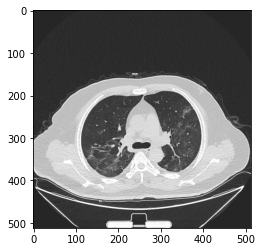

Your lung has benn affected by Covid-19

-----------------------------------



In [45]:
covid_prediction('D:/Datasets/COVID-CT/pCT62.jpg')